# Gabor filter :
These filters have been shown to possess optimal localization properties in both spatial and frequency domains and thus are well-suited for texture segmentation problems.
Gabor filters are special classes of bandpass filters, i.e., they allow a certain ‘band’ of frequencies and reject the others. A Gabor filter can be viewed as a sinusoidal signal of particular frequency and orientation, modulated by a Gaussian wave

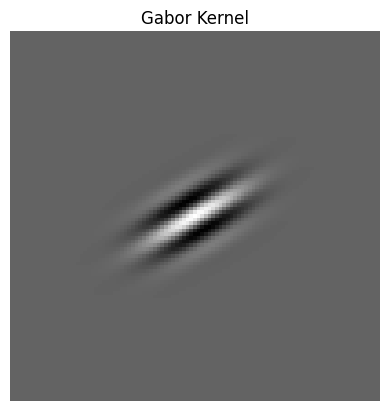

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

ksize = (100, 100)        # Kernel size
sigma = 5               # Standard deviation of the Gaussian envelope
theta = np.pi / 3      # Orientation angle in radians
lambd = 10             # Wavelength of the sinusoidal wave
gamma = 0.5             # Aspect ratio
psi = 0                 # Phase offset

gabor_kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi)
plt.imshow(gabor_kernel, cmap='gray')
plt.title('Gabor Kernel')
plt.axis('off')
plt.show()


### Gabor Kernel Formula
The Gabor kernel \( g(x, y) \) is defined as:

$$
g(x, y; \lambda, \theta, \psi, \sigma, \gamma) = \exp\left(-\frac{x'^2 + \gamma^2 y'^2}{2 \sigma^2}\right) \cos\left(2 \pi \frac{x'}{\lambda} + \psi\right)
$$

Where:
- $ x' = x \cos(\theta) + y \sin(\theta) $: The rotated x-coordinate.
- $ y' = -x \sin(\theta) + y \cos(\theta) $: The rotated y-coordinate.

### Parameters:
1. **$\lambda$ (Wavelength)**: The distance between consecutive peaks of the sinusoidal wave.
2. **$\theta$ (Orientation)**: The angle of the normal to the parallel stripes of the Gabor function.
3. **$\psi$ (Phase Offset)**: The phase of the sinusoidal wave (e.g., 0 for cosine, \(\pi/2\) for sine).
4. **$\sigma$ (Standard Deviation)**: The width of the Gaussian envelope, controlling the scale of the filter.
5. **$\gamma$ (Aspect Ratio)**: The ratio between the x and y dimensions of the Gaussian envelope. A value less than 1 elongates the filter along the orientation axis.

### Components:
1. **Gaussian Envelope**:
   $$
   \exp\left(-\frac{x'^2 + \gamma^2 y'^2}{2 \sigma^2}\right)
   $$

2. **Sinusoidal Component**:
   $$
   \cos\left(2 \pi \frac{x'}{\lambda} + \psi\right)
   $$

The kernel combines these two components to detect features in an image with specific frequencies, orientations, and scales.


In [8]:
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

image = cv2.imread('lab3_images/training/IMD016.bmp', cv2.IMREAD_GRAYSCALE)
label = cv2.imread('lab3_images/training/IMD016_label.bmp', cv2.IMREAD_GRAYSCALE)
if label is None:
    raise ValueError("Failed to load IMD016_label.BMP. Ensure the file format is correct.")

# get different combination for the params of the gabor kernel
def generate_gabor_kernels():
    kernels = []
    for theta in range(8):  # 8 orientations
        theta_rad = theta * np.pi / 4
        for sigma in (1, 4):  # 3 scales
            for lamda in (8, 16):  # 2 wavelengths
                kernel = cv2.getGaborKernel((15, 15), sigma, theta_rad, lamda, 0.5, 0, ktype=cv2.CV_32F)
                kernels.append(kernel)
    return kernels

kernels = generate_gabor_kernels()




In [9]:
import os
print(os.path.exists('lab3_images/training/IMD016_label.bmp'))

True


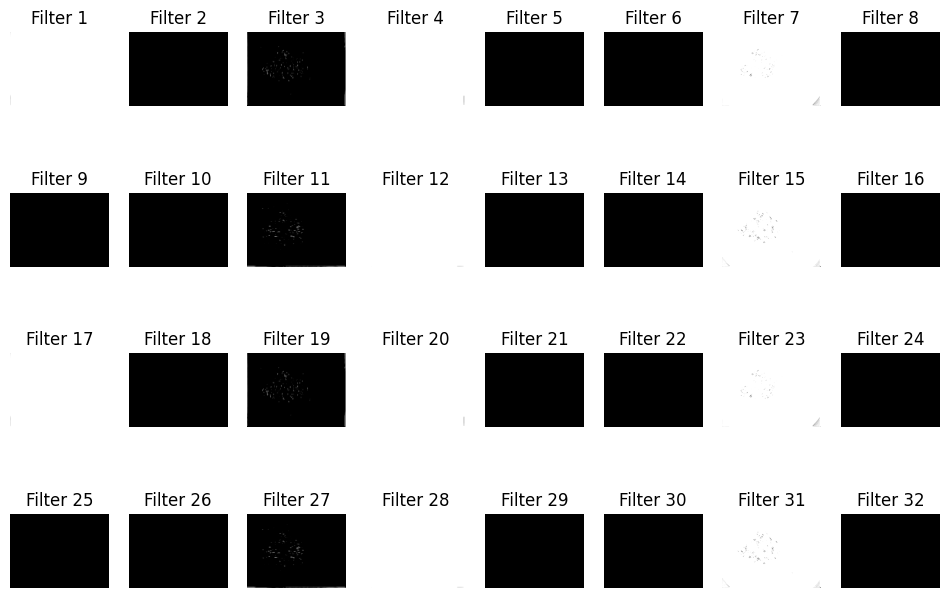

In [10]:
# apply yhe gabor filter on the image
filtered_images = [cv2.filter2D(image, cv2.CV_8UC3, kernel) for kernel in kernels]

plt.figure(figsize=(12, 8))
for i, (kernel, filtered) in enumerate(zip(kernels, filtered_images)):
    plt.subplot(4, len(kernels) // 4, i + 1)
    plt.imshow(filtered, cmap='gray')
    plt.title(f'Filter {i+1}')
    plt.axis('off')
plt.show()



In [11]:
def extract_features(image, kernels, original_image=None):
    gabor_features = [cv2.filter2D(image, cv2.CV_8UC3, kernel).flatten() for kernel in kernels]
    if original_image is not None:
        original_feature = original_image.flatten()
        features = np.vstack([original_feature] + gabor_features).T  
    else:
        # use only Gabor features
        features = np.vstack(gabor_features).T  
    return features


In [12]:
X_train = extract_features(image, kernels, original_image=image)
y_train = label.flatten()  
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

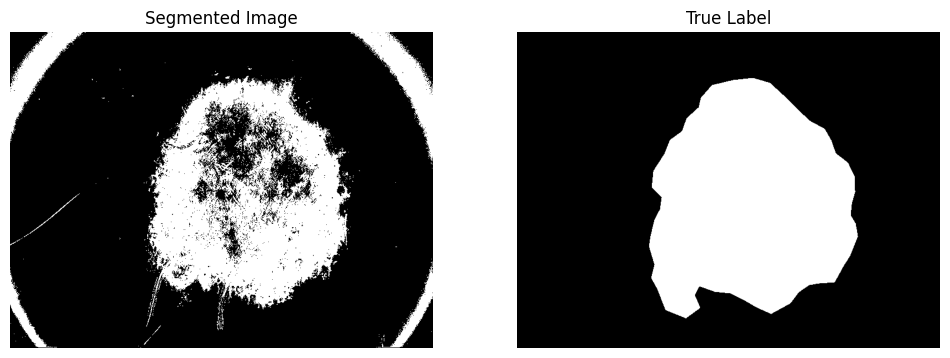

In [13]:
test_image = cv2.imread('lab3_images/testing/IMD002.bmp', cv2.IMREAD_GRAYSCALE)
X_test = extract_features(test_image, kernels, original_image=test_image)
y_pred = clf.predict(X_test)
segmented_image = y_pred.reshape(test_image.shape)

true_label = cv2.imread('lab3_images/testing/IMD002_label.bmp', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(true_label, cmap='gray')
plt.title('True Label')
plt.axis('off')
plt.show()